In [1]:
import numpy as np
import os
# import re
# import shutil
from datetime import datetime, timedelta
import pandas as pd
from glob import glob
import xarray as xr
# import netCDF4
import sys
from DA_operators import operator_clm_SMAP, operator_clm_FLX, haversine_distance
import matplotlib.pyplot as plt
import pickle

def save_dict_to_pickle(dictionary, filename):
    with open(filename, 'wb') as file:
        pickle.dump(dictionary, file)
    print(f"Dictionary saved to {filename}")

# 2. Load a pickle file back to a Python dict
def load_dict_from_pickle(filename):
    with open(filename, 'rb') as file:
        loaded_dict = pickle.load(file)
    print(f"Dictionary loaded from {filename}")
    return loaded_dict


folder_results = '/p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5'
thres_dx = 50
n_ensemble = 64
n_iter = 5
last_iter_ML_only = True #settings_DA['last_iter_ML_only']
# iterations_plot = [0,3,6,7] #0: OL, -1: n_iter
iterations_plot = [0,1,2,3,4,5] #0: OL, -1: n_iter

if folder_results not in sys.path:
    sys.path.insert(0,os.path.join(folder_results,'settings'))
    
from settings import settings_run,settings_clm,settings_pfl,settings_sbatch,settings_DA,settings_gen,date_results_binned,freq_output,date_range_noleap

dir_figs = os.path.join(folder_results,'figures/01_SMAP_per_loc')
if not os.path.exists(dir_figs):
    print('Creating folder to store FLX information: %s' % (dir_figs) )
    os.makedirs(dir_figs)
    
eCLM_dz = np.array([0.02,0.04,0.06,0.08,0.120,
                    0.160,0.200,0.240,0.280,0.320,
                    0.360,0.400,0.440,0.540,0.640,
                    0.740,0.840,0.940,1.040,1.140,
                    2.390,4.676,7.635,11.140,15.115])

data_SMAP_sample = load_dict_from_pickle(os.path.join(folder_results,'figures/01_SMAP_per_loc','%s.pickle'%'DE-Obe')) #just a random station to load in the dates
date_results_iter = data_SMAP_sample['date_results_iter']
date_start_sim = date_results_iter[0][0]
date_end_sim = date_results_iter[0][-1]

# i_date = 0
# date_results_iter = date_results_binned[i_date].copy()
# date_start_sim = date_results_binned[i_date][0][0]#datetime(2019,1,2,12,0,0)
# date_end_sim = date_results_binned[i_date][-1][-1]#datetime(2019,12,31,12,0,0)

# dir_setup = settings_run['dir_setup']
dir_setup = folder_results
str_date = str(date_start_sim.date()).replace('-','') + '-' + str(date_end_sim.date()).replace('-','')
dir_date = os.path.join(dir_setup,str_date)


operator = {}
data_measured = {}
data_latlon = {}
data_var = {}
data_date = {}

operator['FLX'] = operator_clm_FLX(settings_DA['file_lsm'],settings_DA['file_corner'],settings_DA['folder_FLX'],ignore_rivers=False)
data_measured['FLX'],data_var['FLX'],data_latlon['FLX'] = operator['FLX'].get_measurements(date_results_iter,
                                                                                           date_DA_start=date_start_sim,
                                                                                           return_latlon=True)

Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/DE-Obe.pickle
No corrected LE values found for BE-Bra
No corrected LE values found for BE-Dor
No corrected LE values found for BE-Lcr
No corrected LE values found for BE-Maa
No corrected LE values found for CH-Aws
No corrected LE values found for CH-Dav
No corrected LE values found for CH-Fru
No corrected LE values found for CH-Lae
No corrected LE values found for CH-Oe2
No corrected LE values found for CZ-Lnz
No corrected LE values found for CZ-Stn
No corrected LE values found for DE-Akm
No corrected LE values found for DE-RuW
No corrected LE values found for DK-Gds
No corrected LE values found for DK-Sor
No corrected LE values found for ES-Agu
No corrected LE values found for FI-Ken
No corrected LE values found for FI-Qvd
No corrected LE values found for FI-Sii
No corrected LE values found for FR-FBn
No corrected LE values found for FR-Fon
No corrected LE

In [211]:
array_FLX_station = {}
array_date_station = {}

for i_iter in [0,5]:

# i_iter = 5
    str_iter = 'i%3.3i' % i_iter
    dir_iter = os.path.join(dir_date,str_iter)
    settings_run['dir_iter'] = dir_iter

    i_DA = 0
    i_OL = int(sorted(glob(os.path.join(dir_iter,'*')))[-1][-3:]) # the OL simulation

    array_FLX_station[i_iter] = {}
    array_date_station[i_iter] = {}

    for i1,i_real in enumerate(np.arange(i_OL+1)):
        _ = operator['FLX'].interpolate_model_results(i_real,settings_run,retain_history=True,reread_history=False)

        for station_ in operator['FLX'].data_TSMP_i.keys():
            # for station in stations:
            # station_ = 'ES-LM2'
            dates = np.array(list(operator['FLX'].data_TSMP_i[station_].keys()))
            vals = np.array(list(operator['FLX'].data_TSMP_i[station_].values()))

            if i1 == 0:
                array_FLX_station[i_iter][station_] = np.nan*np.zeros([i_OL+1,len(vals)])
                array_date_station[i_iter][station_] = dates
            array_FLX_station[i_iter][station_][i_real,:] = vals

    

Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/20190101-20191230/i000/R000/data_FLX.pickle
Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/20190101-20191230/i000/R001/data_FLX.pickle
Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/20190101-20191230/i000/R002/data_FLX.pickle
Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/20190101-20191230/i000/R003/data_FLX.pickle
Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/20190101-20191230/i000/R004/data_FLX.pickle
Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/20190101-20191230/i000/R005/data_FLX.pickle
Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_

Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/BE-Lon.pickle


/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/BE-Vie.pickle


/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/CH-Cha.pickle


/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/CZ-BK1.pickle
Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/CZ-KrP.pickle
Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/CZ-RAJ.pickle
Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/CZ-wet.pickle
Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/DE-Geb.pickle
Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/DE-Gri.pickle
Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc

/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/FI-Let.pickle


/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/FI-Var.pickle
Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/FR-Aur.pickle
Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/FR-Bil.pickle
Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/FR-Gri.pickle
Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/FR-Hes.pickle
Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/FR-Lam.pickle
Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc

/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/IT-Lsn.pickle
Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/IT-MBo.pickle


/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/IT-SR2.pickle
Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/IT-Tor.pickle


/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/RU-Fy2.pickle


/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/RU-Fyo.pickle


/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/SE-Deg.pickle


/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/SE-Htm.pickle
Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/SE-Nor.pickle


/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/SE-Ros.pickle


/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/SE-Svb.pickle


/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


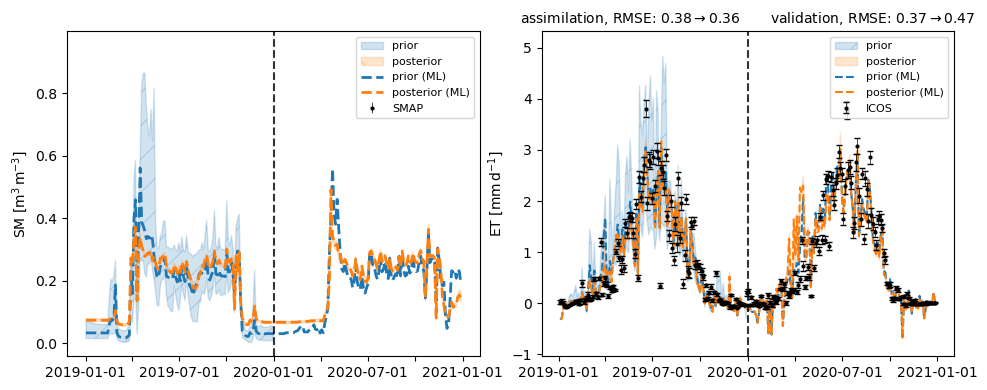

In [281]:
for station_ in list(operator['FLX'].data_TSMP_i.keys()):
# station_ = 'ES-LM2'
    try:
        data_SMAP = load_dict_from_pickle(os.path.join(folder_results,'figures/01_SMAP_per_loc','%s.pickle'%station_))

        # colors = ['#1b9e77','#d95f02','#7570b3']
        colors = [plt.cm.tab10(i) for i in range(10)]
        hatches = ['/', '\\', '|', '-']*3
        fontsize_ = 10
        fontsize_l = 8

        %matplotlib inline
        cmap = plt.cm.tab10
        fig,axes = plt.subplots(1,2,figsize=(10,4))

        ### SMAP
        dates_smap = np.unique(data_SMAP['date_results_iter'])
        i_OL = data_SMAP['i_OL']
        axes[0].fill_between(np.unique(data_SMAP['date_results_iter'][0]), np.nanmin(data_SMAP['results_clm'][0][1:i_OL],axis=0), np.nanmax(data_SMAP['results_clm'][0][1:i_OL],axis=0), color=colors[0],hatch=hatches[0],alpha=.2,label='prior')
        axes[0].fill_between(dates_smap, np.nanmin(data_SMAP['results_clm'][5][1:i_OL],axis=0), np.nanmax(data_SMAP['results_clm'][5][1:i_OL],axis=0), color=colors[1],hatch=hatches[1],alpha=.2,label='posterior')
        axes[0].plot(dates_smap, data_SMAP['results_clm'][5][i_OL], '--', linewidth=2, color=colors[0],label='prior (ML)')
        axes[0].plot(dates_smap, data_SMAP['results_clm'][5][0], '--', linewidth=2, color=colors[1],label='posterior (ML)')

        mask_def = ~np.isnan(data_SMAP['results_smap'][5])
        axes[0].errorbar(np.unique(data_SMAP['date_results_iter'])[mask_def[0,:]],data_SMAP['results_smap'][5][mask_def],
                     0.04*np.ones(mask_def.sum()),fmt='o',color='k',markersize=2,capsize=2,alpha=1.,linewidth=.5,label='SMAP')
        axes[0].set_xticks(pd.date_range(datetime(2019,1,1),datetime(2021,1,1),freq='3MS'))
        for label in axes[0].get_xticklabels()[1::2]:
            label.set_visible(False)
        axes[0].tick_params(axis='both', labelsize=fontsize_)

        (ymin,ymax) = axes[0].get_ylim()
        ymax*=1.1
        axes[0].plot([datetime(2020,1,1),datetime(2020,1,1)],[ymin,ymax],'k--',alpha=.8)
        axes[0].set_ylim([ymin,ymax])
        axes[0].legend(loc='upper right',fontsize=fontsize_l)
        axes[0].set_ylabel('SM [m$^3\,$m$^{-3}$]',fontsize=fontsize_)

        mask_train = (dates_smap < datetime(2020,1,1))
        mask_nan_train = np.isnan(data_SMAP['results_smap'][5][0][mask_train])
        mask_nan_val = np.isnan(data_SMAP['results_smap'][5][0][~mask_train])
        # data_SMAP['results_clm'][5][i_OL][mask_train][~mask_nan].shape
        # data_SMAP['results_smap'][5][0][mask_train][~mask_nan].shape
        rmse_post_train = np.sqrt(np.mean( ( data_SMAP['results_smap'][5][0][mask_train][~mask_nan_train]-data_SMAP['results_clm'][5][0][mask_train][~mask_nan_train] )**2 ) )
        rmse_post_val = np.sqrt(np.mean( ( data_SMAP['results_smap'][5][0][~mask_train][~mask_nan_val]-data_SMAP['results_clm'][5][0][~mask_train][~mask_nan_val] )**2 ) )
        rmse_prior_train = np.sqrt(np.mean( ( data_SMAP['results_smap'][5][0][mask_train][~mask_nan_train]-data_SMAP['results_clm'][5][i_OL][mask_train][~mask_nan_train] )**2 ) ) 
        rmse_prior_val = np.sqrt(np.mean( ( data_SMAP['results_smap'][5][0][~mask_train][~mask_nan_val]-data_SMAP['results_clm'][5][i_OL][~mask_train][~mask_nan_val] )**2 ) )

        str_title = ''
        if not np.isnan(rmse_post_train):
            str_title += r'assimilation, RMSE: %2.2f$\rightarrow$%2.2f       ' % (rmse_prior_train,rmse_post_train)
        if not np.isnan(rmse_post_val):
            str_title += r'validation, RMSE: %2.2f$\rightarrow$%2.2f' % (rmse_prior_val,rmse_post_val)
        axes[0].set_title(str_title,fontsize=fontsize_)


        ### ICOS
        axes[1].fill_between(array_date_station[0][station_], np.nanmin(array_FLX_station[0][station_][1:-1,:],axis=0), np.nanmax(array_FLX_station[0][station_][1:-1,:],axis=0), color=colors[0],hatch=hatches[0],alpha=.2,label='prior')
        axes[1].fill_between(array_date_station[5][station_], np.nanmin(array_FLX_station[5][station_][1:-1,:],axis=0), np.nanmax(array_FLX_station[5][station_][1:-1,:],axis=0), color=colors[1],hatch=hatches[1],alpha=.2,label='posterior')
        axes[1].plot(array_date_station[5][station_],array_FLX_station[5][station_][-1,:],'--',color=colors[0],label='prior (ML)')
        axes[1].plot(array_date_station[5][station_],array_FLX_station[5][station_][0,:],'--',color=colors[1],label='posterior (ML)')
        axes[1].errorbar(operator['FLX'].data_flx[station_]['LE_CORR'].keys(),operator['FLX'].data_flx[station_]['LE_CORR'].values(),
                     list(operator['FLX'].data_flx[station_]['LE_RANDUNC'].values()),fmt='o',color='k',markersize=2,capsize=2,alpha=1.,linewidth=.5,label='ICOS')

        axes[1].set_xticks(pd.date_range(datetime(2019,1,1),datetime(2021,1,1),freq='3MS'))
        for label in axes[1].get_xticklabels()[1::2]:
            label.set_visible(False)
        axes[1].tick_params(axis='both', labelsize=fontsize_)   

        minval = np.min([np.nanmin(array_FLX_station[5][station_]),np.nanmin(array_FLX_station[0][station_])])
        maxval = np.max([np.nanmax(array_FLX_station[5][station_]),np.nanmax(array_FLX_station[0][station_])])
        if minval < 0:
            minval_plt = 1.5*minval
        else:
            minval_plt = 0.5*minval

        axes[1].plot([datetime(2020,1,1),datetime(2020,1,1)],[minval_plt,1.1*maxval],'k--',alpha=.8)
        axes[1].set_ylim([minval_plt,1.1*maxval])
        axes[1].legend(loc='upper right',fontsize=fontsize_l)
        axes[1].set_ylabel('ET [mm$\,$d$^{-1}$]',fontsize=fontsize_)

        mask_train = (array_date_station[5][station_] < datetime(2020,1,1))
        rmse_post_train = np.sqrt(np.mean( ( np.array(list(operator['FLX'].data_flx[station_]['LE_CORR'].values()))[mask_train]-array_FLX_station[5][station_][0,:][mask_train])**2 ) )
        rmse_post_val = np.sqrt(np.mean( ( np.array(list(operator['FLX'].data_flx[station_]['LE_CORR'].values()))[~mask_train]-array_FLX_station[5][station_][0,:][~mask_train])**2 ) )
        rmse_prior_train = np.sqrt(np.mean( ( np.array(list(operator['FLX'].data_flx[station_]['LE_CORR'].values()))[mask_train]-array_FLX_station[5][station_][-1,:][mask_train])**2 ) )
        rmse_prior_val = np.sqrt(np.mean( ( np.array(list(operator['FLX'].data_flx[station_]['LE_CORR'].values()))[~mask_train]-array_FLX_station[5][station_][-1,:][~mask_train])**2 ) )

        str_title = ''
        if not np.isnan(rmse_post_train):
            str_title += r'assimilation, RMSE: %2.2f$\rightarrow$%2.2f       ' % (rmse_prior_train,rmse_post_train)
        if not np.isnan(rmse_post_val):
            str_title += r'validation, RMSE: %2.2f$\rightarrow$%2.2f' % (rmse_prior_val,rmse_post_val)
        axes[1].set_title(str_title,fontsize=fontsize_)


        fig.tight_layout()
        plt.subplots_adjust(wspace=0.15)

        fig.savefig(os.path.join(dir_figs,'SMAP_ICOS_%s_small.png'%station_))
        fig.savefig(os.path.join(dir_figs,'SMAP_ICOS_%s_small.pdf'%station_))

    except:
        print(station_)

Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/BE-Lon.pickle


/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/BE-Vie.pickle


/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/CH-Cha.pickle


/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/CZ-BK1.pickle
Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/CZ-KrP.pickle
Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/CZ-RAJ.pickle
Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/CZ-wet.pickle
Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/DE-Geb.pickle
Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/DE-Gri.pickle
Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc

/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/FI-Let.pickle


/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/FI-Var.pickle
Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/FR-Aur.pickle
Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/FR-Bil.pickle
Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/FR-Gri.pickle
Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/FR-Hes.pickle
Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/FR-Lam.pickle
Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc

/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/IT-Lsn.pickle
Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/IT-MBo.pickle


/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/IT-SR2.pickle
Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/IT-Tor.pickle


/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/RU-Fy2.pickle


/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/RU-Fyo.pickle


/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/SE-Deg.pickle


/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/SE-Htm.pickle
Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/SE-Nor.pickle


/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/SE-Ros.pickle


/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Dictionary loaded from /p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v14_1y_iter5/figures/01_SMAP_per_loc/SE-Svb.pickle


/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/p/software/juwels/stages/2023/software/SciPy-bundle/2022.05-gcccoremkl-11.3.0-2022.1.0/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


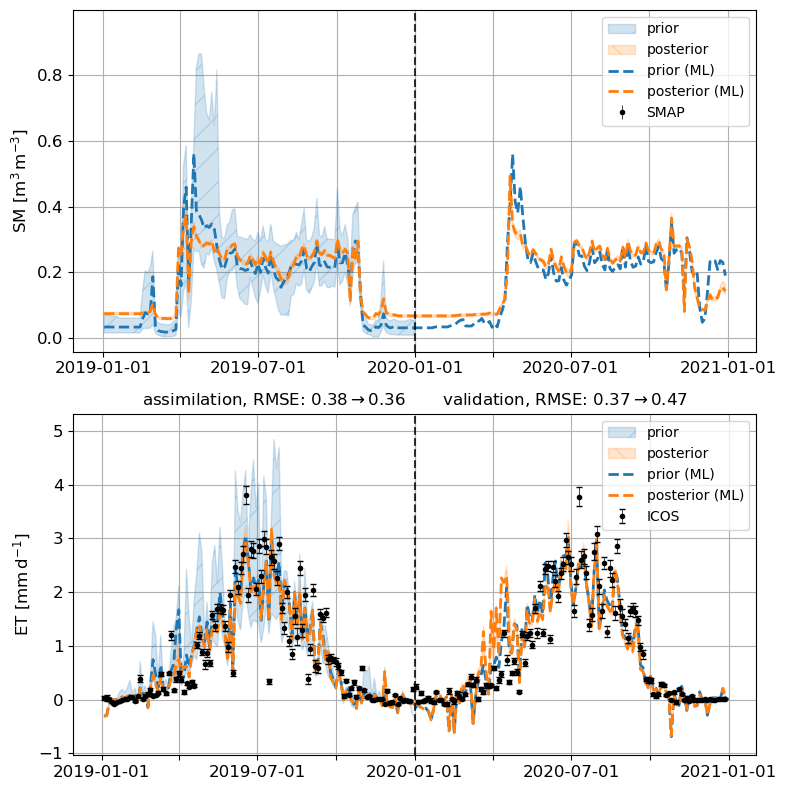

In [280]:
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import AutoMinorLocator

for station_ in list(operator['FLX'].data_TSMP_i.keys()):
# station_ = 'ES-LM2'
    try:
# station_ = 'ES-LM2'
        data_SMAP = load_dict_from_pickle(os.path.join(folder_results,'figures/01_SMAP_per_loc','%s.pickle'%station_))

        # colors = ['#1b9e77','#d95f02','#7570b3']
        colors = [plt.cm.tab10(i) for i in range(10)]
        hatches = ['/', '\\', '|', '-']*3
        fontsize_ = 12
        fontsize_l = 10
        markersize_ = 3

        %matplotlib inline
        cmap = plt.cm.tab10
        fig,axes = plt.subplots(2,1,figsize=(8,8))

        ### SMAP
        dates_smap = np.unique(data_SMAP['date_results_iter'])
        i_OL = data_SMAP['i_OL']
        axes[0].fill_between(np.unique(data_SMAP['date_results_iter'][0]), np.nanmin(data_SMAP['results_clm'][0][1:i_OL],axis=0), np.nanmax(data_SMAP['results_clm'][0][1:i_OL],axis=0), color=colors[0],hatch=hatches[0],alpha=.2,label='prior')
        axes[0].fill_between(dates_smap, np.nanmin(data_SMAP['results_clm'][5][1:i_OL],axis=0), np.nanmax(data_SMAP['results_clm'][5][1:i_OL],axis=0), color=colors[1],hatch=hatches[1],alpha=.2,label='posterior')
        axes[0].plot(dates_smap, data_SMAP['results_clm'][5][i_OL], '--', linewidth=2, color=colors[0],label='prior (ML)')
        axes[0].plot(dates_smap, data_SMAP['results_clm'][5][0], '--', linewidth=2,color=colors[1],label='posterior (ML)')
        
        mask_def = ~np.isnan(data_SMAP['results_smap'][5])
        axes[0].errorbar(np.unique(data_SMAP['date_results_iter'])[mask_def[0,:]],data_SMAP['results_smap'][5][mask_def],
                     0.04*np.ones(mask_def.sum()),fmt='o',color='k',markersize=markersize_,capsize=2,alpha=1.,linewidth=.5,label='SMAP')
      
        axes[0].set_xticks(pd.date_range(datetime(2019,1,1),datetime(2021,1,1),freq='3MS'))
        for label in axes[0].get_xticklabels()[1::2]:
            label.set_visible(False)
        axes[0].tick_params(axis='both', labelsize=fontsize_)

        (ymin,ymax) = axes[0].get_ylim()
        ymax*=1.1
        axes[0].plot([datetime(2020,1,1),datetime(2020,1,1)],[ymin,ymax],'k--',alpha=.8)
        axes[0].set_ylim([ymin,ymax])
        axes[0].legend(loc='upper right',fontsize=fontsize_l)
        axes[0].set_ylabel('SM [m$^3\,$m$^{-3}$]',fontsize=fontsize_)
        
        mask_train = (dates_smap < datetime(2020,1,1))
        mask_nan_train = np.isnan(data_SMAP['results_smap'][5][0][mask_train])
        mask_nan_val = np.isnan(data_SMAP['results_smap'][5][0][~mask_train])
        # data_SMAP['results_clm'][5][i_OL][mask_train][~mask_nan].shape
        # data_SMAP['results_smap'][5][0][mask_train][~mask_nan].shape
        rmse_post_train = np.sqrt(np.mean( ( data_SMAP['results_smap'][5][0][mask_train][~mask_nan_train]-data_SMAP['results_clm'][5][0][mask_train][~mask_nan_train] )**2 ) )
        rmse_post_val = np.sqrt(np.mean( ( data_SMAP['results_smap'][5][0][~mask_train][~mask_nan_val]-data_SMAP['results_clm'][5][0][~mask_train][~mask_nan_val] )**2 ) )
        rmse_prior_train = np.sqrt(np.mean( ( data_SMAP['results_smap'][5][0][mask_train][~mask_nan_train]-data_SMAP['results_clm'][5][i_OL][mask_train][~mask_nan_train] )**2 ) ) 
        rmse_prior_val = np.sqrt(np.mean( ( data_SMAP['results_smap'][5][0][~mask_train][~mask_nan_val]-data_SMAP['results_clm'][5][i_OL][~mask_train][~mask_nan_val] )**2 ) )

        str_title = ''
        if not np.isnan(rmse_post_train):
            str_title += r'assimilation, RMSE: %2.2f$\rightarrow$%2.2f       ' % (rmse_prior_train,rmse_post_train)
        if not np.isnan(rmse_post_val):
            str_title += r'validation, RMSE: %2.2f$\rightarrow$%2.2f' % (rmse_prior_val,rmse_post_val)
        axes[0].set_title(str_title,fontsize=fontsize_)
        axes[0].set_axisbelow(True)
        axes[0].grid(which='major')
        


        
        ### ICOS
        axes[1].fill_between(array_date_station[0][station_], np.nanmin(array_FLX_station[0][station_][1:-1,:],axis=0), np.nanmax(array_FLX_station[0][station_][1:-1,:],axis=0), color=colors[0],hatch=hatches[0],alpha=.2,label='prior')
        axes[1].fill_between(array_date_station[5][station_], np.nanmin(array_FLX_station[5][station_][1:-1,:],axis=0), np.nanmax(array_FLX_station[5][station_][1:-1,:],axis=0), color=colors[1],hatch=hatches[1],alpha=.2,label='posterior')
        axes[1].plot(array_date_station[5][station_],array_FLX_station[5][station_][-1,:],'--',linewidth=2,color=colors[0],label='prior (ML)')
        axes[1].plot(array_date_station[5][station_],array_FLX_station[5][station_][0,:],'--',linewidth=2,color=colors[1],label='posterior (ML)')
        axes[1].errorbar(operator['FLX'].data_flx[station_]['LE_CORR'].keys(),operator['FLX'].data_flx[station_]['LE_CORR'].values(),
                     list(operator['FLX'].data_flx[station_]['LE_RANDUNC'].values()),fmt='o',color='k',markersize=markersize_,capsize=2,alpha=1.,linewidth=.5,label='ICOS')

        axes[1].set_xticks(pd.date_range(datetime(2019,1,1),datetime(2021,1,1),freq='3MS'))
        for label in axes[1].get_xticklabels()[1::2]:
            label.set_visible(False)
        axes[1].tick_params(axis='both', labelsize=fontsize_)

        minval = np.min([np.nanmin(array_FLX_station[5][station_]),np.nanmin(array_FLX_station[0][station_])])
        maxval = np.max([np.nanmax(array_FLX_station[5][station_]),np.nanmax(array_FLX_station[0][station_])])
        if minval < 0:
            minval_plt = 1.5*minval
        else:
            minval_plt = 0.5*minval

        axes[1].plot([datetime(2020,1,1),datetime(2020,1,1)],[minval_plt,1.1*maxval],'k--',alpha=.8)
        axes[1].set_ylim([minval_plt,1.1*maxval])
        axes[1].legend(loc='upper right',fontsize=fontsize_l)
        axes[1].set_ylabel('ET [mm$\,$d$^{-1}$]',fontsize=fontsize_)

        mask_train = (array_date_station[5][station_] < datetime(2020,1,1))
        rmse_post_train = np.sqrt(np.mean( ( np.array(list(operator['FLX'].data_flx[station_]['LE_CORR'].values()))[mask_train]-array_FLX_station[5][station_][0,:][mask_train])**2 ) )
        rmse_post_val = np.sqrt(np.mean( ( np.array(list(operator['FLX'].data_flx[station_]['LE_CORR'].values()))[~mask_train]-array_FLX_station[5][station_][0,:][~mask_train])**2 ) )
        rmse_prior_train = np.sqrt(np.mean( ( np.array(list(operator['FLX'].data_flx[station_]['LE_CORR'].values()))[mask_train]-array_FLX_station[5][station_][-1,:][mask_train])**2 ) )
        rmse_prior_val = np.sqrt(np.mean( ( np.array(list(operator['FLX'].data_flx[station_]['LE_CORR'].values()))[~mask_train]-array_FLX_station[5][station_][-1,:][~mask_train])**2 ) )

        str_title = ''
        if not np.isnan(rmse_post_train):
            str_title += r'assimilation, RMSE: %2.2f$\rightarrow$%2.2f       ' % (rmse_prior_train,rmse_post_train)
        if not np.isnan(rmse_post_val):
            str_title += r'validation, RMSE: %2.2f$\rightarrow$%2.2f' % (rmse_prior_val,rmse_post_val)
        axes[1].set_title(str_title,fontsize=fontsize_)
        axes[1].set_axisbelow(True)
        axes[1].grid(which='major')

        fig.tight_layout()

        fig.savefig(os.path.join(dir_figs,'SMAP_ICOS_%s_large.png'%station_))
        fig.savefig(os.path.join(dir_figs,'SMAP_ICOS_%s_large.pdf'%station_))
    except:
        print(station_)